## W207 Spring 2020, Wednesday 6:30pm section, Holloway
#### Kaggle: House Prices: Advanced Regression Techniques
#### Team:  Imran Manji, Madhukar Reddy, Travis Metz

NB:  All models run on some log of sale price.  Reverts to absolute price only in preparation of submission file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import warnings
import seaborn as sns
import os as os
from datetime import date
from datetime import datetime
import math
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict
from mlxtend.regressor import StackingCVRegressor

import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

#this keeps track of model runs
model_history=[]

#where is initial data file
data_directory="house-prices-advanced-regression-techniques"
train_file_name=os.path.join(data_directory, "train.csv")
test_file_name=os.path.join(data_directory, "test.csv")

#used for stacked regressions
train_predictions={}
test_predictions={}
model_list={} #create dict of actual models


/Users/travismetz/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
base_models={'elas': ElasticNet(),
 'svr': LinearSVR(),
 'las': Lasso(),
 'lgb': lgb.LGBMRegressor(),
 'lr': LinearRegression(),
 'rfr': RandomForestRegressor(),
 'xgb': xgb.XGBRegressor(),
 'gbr': GradientBoostingRegressor(),
 'br': BayesianRidge()}

### Misc helper functions
- Transform price up and down using custom log or sigmoid
- Calculate root mean squared error of predicted price versus actual price - used for baseline
- Transform a few features that look numerical but are categorical (done at start)
- Drop price and id from training set

In [3]:
base=np.exp(1) #used for transform function below to set log base
#base=2
#sig_converter=300000

def transform_price_down(price):
    #converted_price_down=1/(1+math.exp(-price/sig_converter)) #sigmoid function
    converted_price_down=math.log(price,base)
    return(converted_price_down)

def transform_price_up(price):
    #converted_price_up=np.log(price/(1-price))*sig_converter
    converted_price_up=base**price
    return(converted_price_up)

#only used for baseline and nn
def rmse(true_labels,predicted_labels,case_name):
    #true_labels_log=true_labels.apply(transform_price_up)
    #predicted_labels_log=list(map(transform_price_up,predicted_labels))
    
    rms_error=mean_squared_error(true_labels,predicted_labels,squared=False)
    print('\nThe RMSE of our',case_name,'is:',f'{rms_error:.3f}')
    return (rms_error)

#three columns look like numbers but should be categorical   
def transform_cat(df):
    cat_cols=['MSSubClass','MoSold','YrSold']
    for col in cat_cols:
        df[col]=df[col].astype(str)
    return (df)

#drop price and id from training set
def drop_price_id(full_train_data): 
    train_data=full_train_data.drop(['SalePrice','Id'],axis=1)
    return(train_data)
 

### Run model and create submission functions

In [4]:
#this function creates a submission csv when given property Id and predicted sale price
def create_submission(test_id, predicted_saleprice_log,description):
    submission_df=pd.DataFrame()
    submission_df['Id']=test_id
    #submission_df['SalePrice']=predicted_saleprice_log.apply(transform_price_up)
    submission_df['SalePrice']=list(map(transform_price_up,predicted_saleprice_log))
    
    
    #where to save submission files
    dt_string = datetime.now().strftime("%d-%m-%Y_%H%M")
    submission_file_name='submission_'+dt_string+'_'+description+'.csv'
    submission_directory='submissions'
    submission_file=os.path.join(submission_directory,submission_file_name)

    submission_df.to_csv(submission_file, index=None)

#run model
def run_model(model_description,model,train_labels,train_data,test_data):
    model.fit(train_data,train_labels)
    
    cv_scores = -cross_val_score(model, train_data, train_labels, cv=5,scoring="neg_root_mean_squared_error")
    rmse_error=np.mean(cv_scores)

    from sklearn.model_selection import cross_validate
    
    print('The RMSE of our',model_description,'is:',f'{rmse_error:.3f}')
   
    test_pred=model.predict(test_data)
    create_submission(test_id,test_pred,model_description)
    model_history.append([datetime.now().strftime("%d-%m-%Y_%H:%M"),model_description,rmse_error])
    
    #print(model_description,model)
    model_list[model_description]=model
    test_predictions[model_description]=test_pred
    train_predictions[model_description]=cross_val_predict(model,train_data,train_labels)
    return (model_list)

### Read in training data

In [5]:
full_train_data=pd.read_csv(train_file_name)
#transforms a few features that look numerical into categorical
full_train_data=transform_cat(full_train_data)
pd.set_option('display.max_columns', None)
print(full_train_data.shape)
full_train_data.head(5)


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Read in test data that going to make predictions on for kaggle submission
This is dataset you make predictions with and submit.  It has no label (ie sales price) in it. It has to be combined with the training set in order to do proper imputation, scaling and encoding of categorical variable.

In [6]:
full_test_data=pd.read_csv(test_file_name)
test_id=full_test_data.Id
full_test_data=full_test_data.drop(['Id'],axis=1)
full_test_data=transform_cat(full_test_data)

print(full_test_data.shape)

(1459, 79)


### Quick description of dataset

In [7]:
#code modeled after piece found in Kaggle notebook
def ames_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)
summary_stats=ames_eda(full_train_data).T
summary_stats


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
null_sum,0,0,0,1369,0,0,37,38,0,0,37,38,0,0,37,0,0,0,0,1,0,0,0,0,0,1179,690,0,0,0,0,0,0,81,81,81,81,81,0,0,0,0,0,0,0,0,0,0,0,0,259,0,0,0,0,8,8,1406,0,0,0,0,0,0,0,0,1453,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null_pct,0.00,0.00,0.00,0.94,0.00,0.00,0.03,0.03,0.00,0.00,0.03,0.03,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.81,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.06,0.06,0.06,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.01,0.01,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dtypes,int64,int64,int64,object,int64,object,object,object,int64,int64,object,object,int64,int64,object,int64,object,object,object,object,int64,object,object,object,object,object,object,int64,object,int64,object,int64,int64,object,object,object,object,float64,int64,int64,object,object,object,int64,int64,object,object,object,int64,object,float64,object,int64,object,object,float64,object,object,int64,object,object,int64,int64,int64,object,int64,object,object,object,object,int64,object,int64,object,int64,int64,object,int64,int64,int64,object
count,1460,1460,1460,91,1460,1460,1423,1422,1460,1460,1423,1422,1460,1460,1423,1460,1460,1460,1460,1459,1460,1460,1460,1460,1460,281,770,1460,1460,1460,1460,1460,1460,1379,1379,1379,1379,1379,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1201,1460,1460,1460,1460,1452,1452,54,1460,1460,1460,1460,1460,1460,1460,1460,7,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
mean,1162.63,346.99,3.41,NaN,2.87,NaN,NaN,NaN,443.64,46.55,NaN,NaN,0.43,0.06,NaN,567.24,NaN,NaN,NaN,NaN,21.95,NaN,NaN,NaN,NaN,NaN,NaN,0.61,NaN,1.57,NaN,472.98,1.77,NaN,NaN,NaN,NaN,1978.51,1515.46,0.38,NaN,NaN,NaN,730.50,1.05,NaN,NaN,NaN,10516.83,NaN,70.05,NaN,5.84,inf,NaN,103.69,NaN,NaN,43.49,inf,NaN,46.66,5.58,6.10,NaN,2.76,NaN,NaN,NaN,NaN,180921.20,NaN,15.06,NaN,6.52,1057.43,NaN,94.24,1971.27,1984.87,inf
median,1087.00,0.00,0.00,NaN,3.00,NaN,NaN,NaN,383.50,0.00,NaN,NaN,0.00,0.00,NaN,477.50,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,2.00,NaN,480.00,2.00,NaN,NaN,NaN,NaN,1980.00,1464.00,0.00,NaN,NaN,NaN,730.50,1.00,NaN,NaN,NaN,9478.50,NaN,69.00,NaN,0.00,50.00,NaN,0.00,NaN,NaN,0.00,6.00,NaN,25.00,5.00,6.00,NaN,0.00,NaN,NaN,NaN,NaN,163000.00,NaN,0.00,NaN,6.00,991.50,NaN,0.00,1973.00,1994.00,2008.00
min,334,0,0,NaN,0,1Fam,NaN,NaN,0,0,NaN,NaN,0,0,NaN,0,N,Artery,Artery,NaN,0,Ex,Ex,AsbShng,AsbShng,NaN,NaN,0,BrkTil,0,Maj1,0,0,NaN,NaN,NaN,NaN,1900.00,334,0,Floor,Ex,1.5Fin,1,0,Ex,Bnk,Gtl,1300,Corner,21.00,IR1,0,120,C (all),0.00,NaN,NaN,0,1,Blmngtn,0,1,1,N,0,NaN,ClyTile,Flat,Abnorml,34900,COD,0,Grvl,2,0,AllPub,0,1872,1950,2006
max,4692,2065,508,NaN,8,TwnhsE,NaN,NaN,5644,1474,NaN,NaN,3,2,NaN,2336,Y,RRNn,RRNn,NaN,552,TA,TA,WdShing,Wd Shng,NaN,NaN,3,Wood,3,Typ,1418,4,NaN,NaN,NaN,NaN,2010.00,5642,2,Wall,TA,SLvl,1460,3,TA,Lvl,Sev,215245,Inside,313.00,Reg,572,90,RM,1600.00,NaN,NaN,15500,9,Veenker,547,9,10,Y,738,NaN,WdShngl,Shed,Partial,755000,WD,480,Pave,14,6110,NoSeWa,857,2010,2010,2010


### Remove a few obvious outliers
This removal is a bit out of sequence as the existence of the outliers and impact on modeling became clearer later in analysis.  But for purposes of keeping coherent datasets that are consistently transformed, wanted to remove upfront.

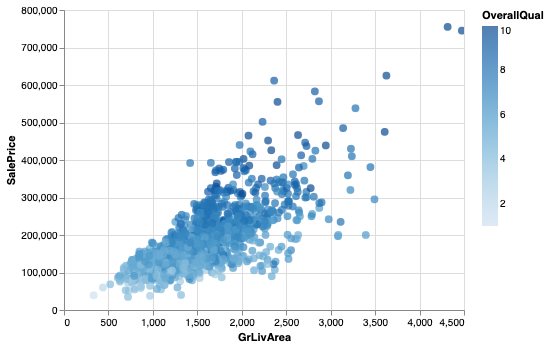

In [13]:
source=full_train_data
alt.renderers.enable('notebook')

alt.Chart(source).mark_circle(size=60).encode(
    x='GrLivArea',
    y='SalePrice',
    color='OverallQual',
    tooltip=['Neighborhood','OverallQual']
).interactive()


In [ ]:
#drop largest outliers
full_train_data = full_train_data.drop(
    full_train_data[(full_train_data.GrLivArea>4000) & (full_train_data.SalePrice<300000)].index)

#drop if no full bath - eliminates ratio problems
full_train_data = full_train_data.drop(
    full_train_data[(full_train_data.FullBath==0)].index)

### Apply transformation to sale price and drop labels from training set

In [14]:
#create labels, drop saleprice and id, log saleprice
train_labels=full_train_data.SalePrice.apply(transform_price_down)
train_data_original=drop_price_id(full_train_data)
train_count=len(train_data_original)

### Pipeline Functions
- imputation- does imputation
- encode- does encoding of variables using a few different methods
- scale- scales data
- full_processing- runs three functions above and is done just before running a model

Conceptually, full_data can be manipulated sequentially and then sent back to this pipeline for processing just before running a model

In [15]:
def create_full_set(train_data,full_test_data): 
    full_data=pd.concat([train_data,full_test_data])
    return (full_data)
    
#impute missing values in simples possible way
def imputation(full_data):    
    
    cat_cols=full_data.select_dtypes(include=['object']).columns.values
    num_cols=set(full_data.columns) - set(cat_cols)
    
    #for any missing numerical column, fill in by median of neighborhood
    for col in num_cols:
        full_data.groupby("Neighborhood")[col].transform(
            lambda x: x.fillna(x.median()))

    #shouldn't be any missing numerical features at this point but still include
    t = [('num', SimpleImputer(strategy='median'), list(num_cols)), 
         ('cat', SimpleImputer(strategy='most_frequent'), list(cat_cols))]
    
    transformer = ColumnTransformer(transformers=t)
    full_data_imp = transformer.fit_transform(full_data)
    
    #turn back into data frame so that have columns and types to do encoding of categoricals
    cat_cols=list(cat_cols)
    num_cols=list(num_cols)
    num_cols.extend(cat_cols)
    full_data_imp=pd.DataFrame(full_data_imp, columns = num_cols).infer_objects()
    return(full_data_imp)
    
def encode(full_data):
    categorical_columns=full_data.select_dtypes(include=['object']).columns
    full_data_enc=pd.get_dummies(full_data,columns=categorical_columns,drop_first=True)
    return(full_data_enc)

def scale(full_data,scaler_type):
    if scaler_type=='standard':
        scaler=StandardScaler().fit(full_data)
        return (scaler.transform(full_data))
    elif scaler_type=='robust':
        scaler=RobustScaler().fit(full_data)
        return(scaler.transform(full_data))
    elif scaler_type=='none':
        return full_data
    
def full_processing(full_data, train_count,scaler_type):
    #full_data=create_full_set(train_data,full_test_data)
    
    full_data_imp=imputation(full_data) #impute
    full_data_enc=encode(full_data_imp) #encode
    full_data_scale=scale(full_data_enc,scaler_type) #scale
    
    train_data=full_data_scale[:train_count]
    test_data=test_data=full_data_scale[train_count:]

    train_columns=full_data_enc.columns
    
    print ('Train data shape:',train_data.shape)
    print ('Test data shape:',test_data.shape)
    print ('Train labels shape:',train_labels.shape)
    
    return(train_data,test_data,train_columns)

### Start running models - first without any parameter optimization or scaling

In [17]:
scaler_type='none'

full_data=create_full_set(train_data_original,full_test_data)
train_data,test_data, train_columns=full_processing(full_data,train_count,scaler_type)

for model in base_models.keys():
    run_model(model,base_models[model],train_labels,train_data,test_data)

Train data shape: (1449, 271)
Test data shape: (1459, 271)
Train labels shape: (1449,)
The RMSE of our elas is: 0.162
The RMSE of our svr is: 0.269
The RMSE of our las is: 0.170
The RMSE of our lgb is: 0.125
The RMSE of our lr is: 0.128
The RMSE of our rfr is: 0.138
The RMSE of our xgb is: 0.134
The RMSE of our gbr is: 0.124
The RMSE of our br is: 0.115


### With standard scaler

In [18]:
scaler_type='standard'

full_data=create_full_set(train_data_original,full_test_data)
train_data,test_data, train_columns=full_processing(full_data,train_count,scaler_type)

for model in base_models.keys():
    run_model(model,base_models[model],train_labels,train_data,test_data)

Train data shape: (1449, 271)
Test data shape: (1459, 271)
Train labels shape: (1449,)
The RMSE of our elas is: 0.397
The RMSE of our svr is: 1.890
The RMSE of our las is: 0.397
The RMSE of our lgb is: 0.125
The RMSE of our lr is: 40698304612.553
The RMSE of our rfr is: 0.137
The RMSE of our xgb is: 0.134
The RMSE of our gbr is: 0.124
The RMSE of our br is: 0.122


### With robust scaler

In [19]:
scaler_type='robust'

full_data=create_full_set(train_data_original,full_test_data)
train_data,test_data, train_columns=full_processing(full_data,train_count,scaler_type)

for model in base_models.keys():
    run_model(model,base_models[model],train_labels,train_data,test_data)

Train data shape: (1449, 271)
Test data shape: (1459, 271)
Train labels shape: (1449,)
The RMSE of our elas is: 0.391
The RMSE of our svr is: 0.265
The RMSE of our las is: 0.391
The RMSE of our lgb is: 0.126
The RMSE of our lr is: 2896.435
The RMSE of our rfr is: 0.136
The RMSE of our xgb is: 0.134
The RMSE of our gbr is: 0.124
The RMSE of our br is: 0.115


### Now run models that were previously subject to hyper-parameter tuning (using robust scaler)
Models above were just 'base' models with default parameters. Models below were tuned (see bottom of notebook) and saved for future loading.

In [22]:
models_file = 'best_models.pkl'
best_models = pickle.load(open(models_file, 'rb'))

scaler_type='robust'
full_data=create_full_set(train_data_original,full_test_data)
train_data,test_data, train_columns=full_processing(full_data,train_count,scaler_type)

for model in best_models.keys():
    run_model(model,best_models[model],train_labels,train_data,test_data)

Train data shape: (1449, 271)
Test data shape: (1459, 271)
Train labels shape: (1449,)
The RMSE of our elas is: 0.114
The RMSE of our svr is: 0.454
The RMSE of our las is: 0.115
The RMSE of our lgb is: 0.123
The RMSE of our lr is: 14434.426
The RMSE of our rfr is: 0.138
The RMSE of our xgb is: 0.120
The RMSE of our gbr is: 0.119
The RMSE of our br is: 0.115


### Feature Work

Broad categories

- There are a number of quality and condition features that are categorical but have a ranking to their values.  Encode the ranking.
- Impute any missing lot frontage with average neighborhood lot frontage
- Create a few new features - total SF, bed/bath ratio, house/lot ratio
- Characterize some missing values as 0 or none, as absence represents null value

In [23]:
full_data=create_full_set(train_data_original,full_test_data)

#create ordinal for list of features related to Quality
quality_columns=['ExterQual','ExterCond','BsmtQual','HeatingQC','KitchenQual',
                 'FireplaceQu','BsmtCond','GarageQual','GarageCond','PoolQC']

encoder = OrdinalEncoder(categories=[["None", "Po", "Fa","TA","Gd","Ex"]])
for col in quality_columns:
    full_data[col].fillna("None",inplace=True)
    encoded_values=encoder.fit_transform(full_data[col].values.reshape(-1, 1))
    full_data[col]=encoded_values


#create ordinal for Functional
encoder = OrdinalEncoder(categories=[["None","Sal", "Sev", "Maj2","Maj1","Mod","Min2","Min1","Typ"]])
col='Functional'
full_data[col].fillna("None",inplace=True)
encoded_values=encoder.fit_transform(full_data[col].values.reshape(-1, 1))
full_data[col]=encoded_values  
    
#create ordinal for basement finish type
encoder = OrdinalEncoder(categories=[["None","Unf", "LwQ", "Rec","BLQ","ALQ","GLQ"]])
col='BsmtFinType1'
full_data[col].fillna("None",inplace=True)
encoded_values=encoder.fit_transform(full_data[col].values.reshape(-1, 1))
full_data[col]=encoded_values
    
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
full_data["LotFrontage"] = full_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#create a few features
full_data['TotalBath']=full_data.FullBath+(0.5*full_data.HalfBath)
full_data['BrBathRatio']=full_data.BedroomAbvGr/full_data.TotalBath
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']
full_data['HouseLotRatio']=full_data['1stFlrSF']/full_data.LotArea

#if feature is NA, these numerical features should be set to zero
zero_columns=['GarageYrBlt', 'GarageArea', 'GarageCars',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea',]
for zero_column in zero_columns:
    full_data[zero_column] = full_data[zero_column].fillna(0)

#if feature is NA, these categorical features should be set to None rather than NA (for imputation)
none_columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType','MSSubClass']
for none_column in none_columns:
    full_data[none_column]=full_data[none_column].fillna("None")

 

### Run models again after feature work

In [24]:
train_predictions={}
test_predictions={}
scaler_type='robust'
train_data,test_data, train_columns=full_processing(full_data,train_count,scaler_type)

model_list={} #create dict of actual models
for model in best_models.keys():
    model_list=run_model(model,best_models[model],train_labels,train_data,test_data)

Train data shape: (1449, 249)
Test data shape: (1459, 249)
Train labels shape: (1449,)
The RMSE of our elas is: 0.113
The RMSE of our svr is: 0.374
The RMSE of our las is: 0.113
The RMSE of our lgb is: 0.122
The RMSE of our lr is: 0.126
The RMSE of our rfr is: 0.133
The RMSE of our xgb is: 0.120
The RMSE of our gbr is: 0.117
The RMSE of our br is: 0.114


### Simple feature importance analysis

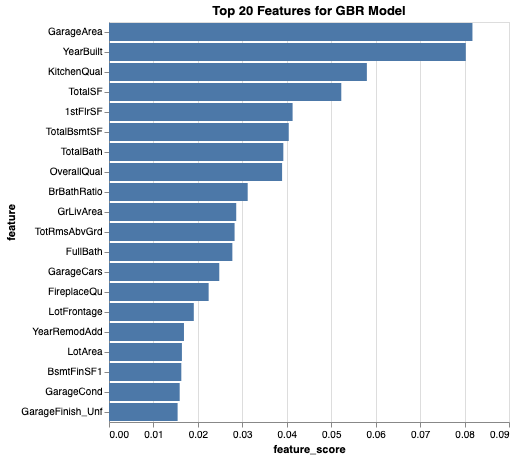

In [25]:
feat_imp = pd.Series(model_list['gbr'].feature_importances_, train_columns).sort_values(ascending=False)
feat_imp=feat_imp[0:20]
temp=pd.DataFrame(feat_imp).reset_index()
temp.columns=['feature','feature_score']
temp=temp.sort_values(['feature_score'],ascending=False)

alt.Chart(temp).mark_bar().encode(
    y=alt.Y('feature',sort='-x'),
    x='feature_score'
    #color='OverallQual',
    #tooltip=['Neighborhood','OverallQual']
).interactive().properties(
    title='Top 20 Features for GBR Model')

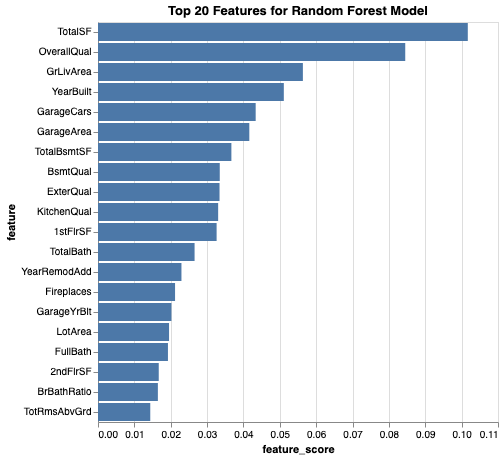

In [26]:
feat_imp = pd.Series(model_list['rfr'].feature_importances_, train_columns).sort_values(ascending=False)
feat_imp=feat_imp[0:20]
temp=pd.DataFrame(feat_imp).reset_index()
temp.columns=['feature','feature_score']
temp=temp.sort_values(['feature_score'],ascending=False)

alt.Chart(temp).mark_bar().encode(
    y=alt.Y('feature',sort='-x'),
    x='feature_score'
    #color='OverallQual',
    #tooltip=['Neighborhood','OverallQual']
).interactive().properties(
    title='Top 20 Features for Random Forest Model')

### Manual stacked regressor
Simple linear regression model fit against predictions of all above models.

In [27]:
train_predictions_df=pd.DataFrame(train_predictions)
test_predictions_df=pd.DataFrame(test_predictions)

model=LinearRegression()
model_description='stacked_lr'
cv_scores = -cross_val_score(model, train_predictions_df, train_labels, cv=5,scoring="neg_root_mean_squared_error")
rmse_error=np.mean(cv_scores)
print('\nThe RMSE of our',model_description,'is:',f'{rmse_error:.3f}')

model.fit(train_predictions_df,train_labels)
test_pred=model.predict(test_predictions_df)
create_submission(test_id,test_pred,model_description)


The RMSE of our stacked_lr is: 0.111


### Stacked regressor - StackingRegressor
Best to choose models with are less correlated with each other.  Further work could be done to analyze correlations between predictions.

In [28]:
selected_models=['elas','rfr',]

stack_models={}
for i in selected_models:
    stack_models[i]=model_list[i]

    
stacked = StackingRegressor(
    estimators=list(stack_models.items()),
    final_estimator=RandomForestRegressor())

scaler_type='robust'
train_data,test_data,train_columns=full_processing(full_data,train_count,scaler_type)
blank=run_model('stacked',stacked,train_labels,train_data,test_data)

Train data shape: (1449, 249)
Test data shape: (1459, 249)
Train labels shape: (1449,)
The RMSE of our stacked is: 0.122


### Stacking regressor - StackingCVRegressor


In [29]:
selected_models=['elas','rfr']

stack_models={}
for i in selected_models:
    stack_models[i]=model_list[i]

stacked = StackingCVRegressor(regressors=list(stack_models.values()),
                            meta_regressor=RandomForestRegressor())

scaler_type='robust'
train_data,test_data,train_columns=full_processing(full_data,train_count,scaler_type)
blank=run_model('stacked',stacked,train_labels,train_data,test_data)


Train data shape: (1449, 249)
Test data shape: (1459, 249)
Train labels shape: (1449,)
The RMSE of our stacked is: 0.122


### Voting Regressor

In [30]:
model1 = best_models['gbr']
model2 = best_models['rfr']
model3 = best_models['xgb']
model4 = best_models['elas']
model5 = best_models['lgb']
model6 = best_models['br']
model1.fit(train_data,train_labels)
model2.fit(train_data,train_labels)
model3.fit(train_data,train_labels)
model4.fit(train_data,train_labels)
model5.fit(train_data,train_labels)
model6.fit(train_data,train_labels)

train_data,test_data,train_columns=full_processing(full_data,train_count,scaler_type)
model=VotingRegressor(estimators=[('gbr', model1), ('rfr', model2), ('xgb', model3),
                                  ('elas',model4),('lgb',model5),('br',model6)])

blank=run_model('voting_regressor_6',model,train_labels,train_data,test_data)


Train data shape: (1449, 249)
Test data shape: (1459, 249)
Train labels shape: (1449,)
The RMSE of our voting_regressor_6 is: 0.112


### Error Analysis using Bayesian Ridge model
Saving results so that can be picked up in separate notebook.

In [31]:
#save model, test_data and test_predictions for error analysis
results=pd.DataFrame([train_labels.values,train_predictions['br']]).T
test=pd.concat([results,pd.DataFrame(train_data)],ignore_index=True,axis=1)
test_columns=['actual','predicted']
test_columns.extend(train_columns)
test.columns=test_columns
test.to_csv('results.csv',index=False)
pickle.dump(model_list['br'], open('br_model', 'wb'))

### PCA for outlier analysis - TODO

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
scaler=StandardScaler()

def do_pca(n_components, data):
  """
  Takes target dimensionality reduction (k) and the data to reduce
  Returns the reduced data
  """
  
  pca = PCA(n_components)
  pca.fit(data)
  reduced_data = pca.transform(data)
  return reduced_data 

# note the filtered version of data passed in here
train_data,test_data,train_columns=full_processing(full_data,train_count)
#full_pca_data=pd.concat([train_data,test_data])

reduced_train_data = do_pca(n_components=10, data=train_data)
pc1, pc2 = reduced_train_data[:, 1], reduced_train_data[:, 2]

import seaborn as sns
colors = ["g", "r"]
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette(sns.color_palette(colors))

# note the filtered version of labels passed in here
sns.scatterplot(x=pc1, y=pc2, hue=train_labels)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

## Appendix

### Optimization of Hyperparameters
Do not run unless required - takes 10-15 minutes.  Best models are loaded at top from prior runs.  Stored in best_models.pkl

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

parameters={
            'elas':{'alpha':np.linspace(0.0005,1,25),
                    'l1_ratio':np.linspace(0.1,1,25)},
            'las':{'alpha':np.linspace(0.001,1,50)},
            'svr':{'C': np.linspace(0.01,0.1,50),
                   #'gamma': [1e-4, 0.5e-3, 1e-3, 1.25e-3],
                  'epsilon':np.linspace(0.005,0.1,50)},    
            'gbr':{'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
                'n_estimators':[100,250,500,1000],
                'max_depth':[2,3,4,10,100],
                'min_samples_split':[2,4,6,8,10,20,40,60,100], 
                'min_samples_leaf':[1,3,5,7,9],
               'max_features':[2,3,4,5,6,7],
               'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]},

            'xgb':{'eta':[.01,.015,.025,.05,.1],
                'gamma':[.05,.1,.3,.5,.7,.9,1.0],
               'max_depth':[3,5,7,9,12,15,17,25],
               'min_child_weight':[1,3,5,7],
               'subsample':[.6,.7,.8,.9,1.0],
               'colsample_bytree':[.6,.7,.8,.9,1.0],
               'lambda':[.01,.1,1.0],
               'alpha':[0,0.1,0.5,1.0]},

            'rfr':{'bootstrap': [True, False],
                 'max_depth': [10, 30, 50, 70, 90, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [50,100,200]},

            'lr':{'fit_intercept':[True,False],'normalize':[True,False]},

            'lgb':{'num_leaves': list(range(8, 92, 10)),
                'min_data_in_leaf': [20, 40],
                'max_depth': [3, 12, -1],
                'learning_rate': [0.1, 0.05, 0.01],
                'bagging_freq': [4, 6],
                'bagging_fraction': [0.6, 0.95],
                'reg_alpha': [0.1,0.95],
                'reg_lambda': [0.1,0.95]},
            
            'br':{'alpha_1': np.linspace(0.01,1,25)}
           }

models={'elas':ElasticNet(),'svr':LinearSVR(),'las':Lasso(),'lgb':lgb.LGBMRegressor(),'lr':LinearRegression(),
        'rfr':RandomForestRegressor(),'xgb':xgb.XGBRegressor(objective ='reg:squarederror'),
        'gbr':GradientBoostingRegressor(),'br':BayesianRidge()}

#took out SVR() and replaced with LinearSVR()
#models={'lgb':lgb.LGBMRegressor(),'lr':LinearRegression(),
#        'rfr':RandomForestRegressor(),'gbr':GradientBoostingRegressor()}


best_models={}
model_scores=[]

train_data,test_data,train_columns=full_processing(full_data,train_count)

for model in models.keys():
    print('working on:',model)
    rs_cv_model=RandomizedSearchCV(models[model],parameters[model],
                         scoring="neg_root_mean_squared_error",
                         verbose=1,n_iter=20)
    
    rs_cv_model.fit(train_data,train_labels)
    best_models[model]=rs_cv_model.best_estimator_
    print (model,'score: ',-rs_cv_model.best_score_)
    model_scores.append([model,-rs_cv_model.best_score_])


#save in pickle file so can be read in at top and does not need to be rerun
import pickle
pickle.dump(best_models, open(models_file, 'wb'))

print(best_models)
print(model_scores)


### Baseline
Baseline is created by using average price per square foot by neighborhood.  Accuracy calculated using RMSE on log of price.  Simulating cross-validation by using 5 different shuffles of data.

In [ ]:
#simulate cross-fold validation - required since no dev set
k=5
results_list=[]
for i in range(k):
    shuffle = np.random.permutation(np.arange(full_train_data.shape[0]))
    full_train_dataBL=full_train_data.iloc[shuffle]
    #full_train_dataBL.SalePrice=np.log(full_train_dataBL.SalePrice)
    
    dev_ratio=1/k
    train_ratio=1-dev_ratio
    
    train_number=round(train_ratio*full_train_dataBL.shape[0])
    dev_number=round(dev_ratio*full_train_dataBL.shape[0])+train_number

    train_dataBL,train_labelsBL=full_train_dataBL[0:train_number
                                                 ],np.log(full_train_dataBL.SalePrice[0:train_number])

    dev_dataBL,dev_labelsBL=full_train_dataBL[train_number:dev_number
                                   ],np.log(full_train_dataBL.SalePrice[train_number:dev_number])

    #add saleprice per square foot
    train_dataBL['pricepersf']=train_dataBL.SalePrice/train_dataBL.GrLivArea

    #create dataframe that shows average price per square foot by neighborhood
    average_price_persf_by_neighborhood=train_dataBL.groupby(['Neighborhood']).pricepersf.mean()
    
    output=pd.DataFrame()
    output['pricepersf']=average_price_persf_by_neighborhood[dev_dataBL.Neighborhood]
    output['grlivarea']=dev_dataBL.GrLivArea.values
    output['pred']=output.pricepersf*output.grlivarea
    output['saleprice']=np.exp(dev_labelsBL.values)
    output['se']=((np.log(output.saleprice)-np.log(output.pred))**2)
    #print(dev_dataBL.shape)
    #print ('\n\nThis is an example of the first five predictions on the dev set and their squared error:')
    #print(output.head(5))
    #rmse_result=rmse(dev_labelsBL,np.log(output.pred),'baseline (using logs of both actual and predicted values)')
    rmse_result=rmse(np.log(output.saleprice),np.log(output.pred),'baseline (using logs of both actual and predicted values)')
    results_list.append(rmse_result)


print("RMSE on logs from cross-validation runs:",results_list)
print(f'Average cross validation RMSE: {np.mean(results_list):.2f}')

### Trying other random models just because ....

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
train_data,test_data,train_columns=full_processing(full_data,train_count,scaler_type)
run_model('knn',KNeighborsRegressor(n_neighbors=9),train_labels,train_data,test_data)
print(KNeighborsRegressor())


### Very ineffective neural net work

In [ ]:
#normalizing for nn

from sklearn.preprocessing import MaxAbsScaler
scaler_x = MaxAbsScaler()
scaler_y = MaxAbsScaler()

scaler_type='none'
train_data,test_data,train_columns=full_processing(full_data,train_count,scaler_type)


print(scaler_x.fit(train_data))
xscale=scaler_x.transform(train_data)
print(scaler_y.fit(train_labels.values.reshape(-1, 1)))
yscale=scaler_y.transform(train_labels.values.reshape(-1,1))

In [ ]:
from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten
from keras.utils import np_utils
from keras import backend as K
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

num_features=train_data.shape[1]

#no idea what model structure should look like
def baseline_model():
    model = Sequential()
    model.add(Dense(40, input_dim=num_features, kernel_initializer='normal',activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])
    return model


model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=50, verbose=1,validation_split=0.2)
model_description='nn_with_scaling'
history=model.fit(xscale,yscale)

#scale test features, predict, then unscale test predictions
testx= scaler_x.transform(test_data)
testy= model.predict(testx)
test_pred = scaler_y.inverse_transform(testy.reshape(-1,1)) 

#in absence of another measure, calculate RMSE on entire train set
trainy_predict_scaled=model.predict(xscale)
train_labels_predict = scaler_y.inverse_transform(trainy_predict_scaled.reshape(-1,1)) 

rmse_error=rmse(train_labels,train_labels_predict,model_description)



#create submission file and add to model_history though RMSE not comparable
create_submission(test_id,test_pred,model_description)
model_history.append([datetime.now().strftime("%d-%m-%Y_%H:%M"),model_description,rmse_error])



### Correlation visual

In [ ]:
#from https://medium.com/swlh/a-complete-guide-to-exploratory-data-analysis-and-data-cleaning-dd282925320f

correlations = full_train_data.corrwith(full_train_data.SalePrice).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);